
# Sustainable Aviation Fuel (SAF) Screening

In‑silico funnel from 5 000 TenGAN‑generated SMILES down to a top candidate SAF molecules for further validation. 

## Stages

1. Canonalisation, validity, uniqueness, novelty checks 
2. Five structural / spec screens  
3. Volumetric energy ranking  
4. Few exploratory visuals  
5. Display the top 12 structures


## Imports & configuration

In [1]:

import os, sys
from pathlib import Path
import pandas as pd, numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import AllChem
from thermo.group_contribution.joback import Joback

plt.rc('figure', dpi=110)
plt.rc('axes', grid=True)


/home/karl/ZH5_Karl/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters

Make wanted changes in here. Especially make sure to amend the filename parameters to the current ones!

In [ ]:

PARAMS = {
    'generated_smiles_csv': Path('generated_smiles_comb_1.csv'), # this is the csv containing the model output. 
    'training_set_csv': Path('comb_1.csv'), # this is the csv file that the model used for training. It is used to check for novelty detection.
    'tanimoto_cutoff': 0.9, # higher values mean that more molecules will be considered novel
    'max_oxygen': 1,
    'allow_N': False,
    'allow_S': False,
    'allow_halogen': False,
    'max_cdouble': 3,
    'Tb_min': 100.0,
    'Tb_max': 340.0,
    'flashpoint_min': 25.0,
    'density_min': 0.70,
    'density_max': 0.90,
}


## Load data

In [3]:

gen_df = pd.read_csv(PARAMS['generated_smiles_csv'], header=None, names=['smiles'])
train_df = pd.read_csv(PARAMS['training_set_csv'], header=None, names=['smiles'])
print(f"Generated set: {len(gen_df):,}, training set: {len(train_df):,}")


import pandas as pd

RING_OK = set(pd.read_csv("chembl_ring_systems.csv")["SMILES"])
print(f"{len(RING_OK):,} ring systems loaded")

Generated set: 3,584, training set: 3,236
55,039 ring systems loaded


## Helper functions

In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from functools import lru_cache
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold

# Suppress warnings from RDKit about MorganGenerator
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

HALOGENS = {'F','Cl','Br','I'}

def mol(s):
    try:
        return Chem.MolFromSmiles(s, sanitize=True)
    except: return None

def cano(s):
    m = mol(s)
    return Chem.MolToSmiles(m, canonical=True) if m else None

train_hashes = {cano(s) for s in train_df.smiles if isinstance(s,str)}

@lru_cache(maxsize=100_000) # cache to speed up the function calls a bit. remove if you want to save memory. 
def fp(m):
    return AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048)

train_fps = [fp(Chem.MolFromSmiles(s)) 
             for s in train_df.smiles 
             if isinstance(s, str) and Chem.MolFromSmiles(s)]

# define is_novel function that compares to the training set
def is_novel(s):
    if not isinstance(s, str): return False
    m = mol(s)
    if m is None: return False
    c_smi = Chem.MolToSmiles(m, canonical=True)
    if c_smi in train_hashes: return False
    f = fp(m)
    for t in train_fps:
        if TanimotoSimilarity(f, t) >= PARAMS['tanimoto_cutoff']:
            return False
    return True


def n_C(m): return sum(a.GetSymbol()=='C' for a in m.GetAtoms())
def n_O(m): return sum(a.GetSymbol()=='O' for a in m.GetAtoms())

def composition_ok(m):
    if n_O(m) > PARAMS['max_oxygen']: return False
    for a in m.GetAtoms():
        s=a.GetSymbol()
        if s=='N' and not PARAMS['allow_N']: return False
        if s=='S' and not PARAMS['allow_S']: return False
        if s in HALOGENS and not PARAMS['allow_halogen']: return False
        if s not in {'C','H','O','N','S',*HALOGENS}: return False
    return True

@lru_cache(maxsize=100_000)
def c_double(m):
    dbl = sum(
        b.GetBondType() == Chem.BondType.DOUBLE and
        all(a.GetSymbol() == "C" for a in (b.GetBeginAtom(), b.GetEndAtom()))
        for b in m.GetBonds()
    )
    arom = rdMolDescriptors.CalcNumAromaticRings(m)
    return dbl + arom


SMART_FORBID = [Chem.MolFromSmarts(p) for p in ('C#C','[CH]=O')]
def forbidden(m): return any(m.HasSubstructMatch(p) for p in SMART_FORBID)

#TODO: find a more recent source instead of Joback, e.g. Marrero & Gani
@lru_cache(maxsize=100_000)
def tb(s: str) -> float:
    try:
        jb = Joback(s)            # fragment the molecule
        return jb.Tb(jb.counts) - 273.15     # K to C
    except Exception:
        return float("nan")

# Improved method needed for flash point calculation
def flash_point(tb_c):
    if np.isnan(tb_c):
        return np.nan
    return 0.30 * tb_c - 15.0

def ring_ok(mol):
    rsmi = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)
    return rsmi in RING_OK

@lru_cache(maxsize=100_000)
def rho(m): 
    return 0.97 - 0.0001*(Descriptors.MolWt(m)-100)

#TODO: find a more recent source for the equation. Consider using a group contribution method or only C/H/O
@lru_cache(maxsize=100_000)
def hhv(m):
    c=h=o=n=s=0
    for a in m.GetAtoms():
        d={'C':'c','H':'h','O':'o','N':'n','S':'s'}.get(a.GetSymbol())
        if d=='c': c+=1
        elif d=='h': h+=1
        elif d=='o': o+=1
        elif d=='n': n+=1
        elif d=='s': s+=1
    mw=Descriptors.MolWt(m)
    wt=lambda n,aw: n*aw/mw*100
    hh=0.3491*wt(c,12.011)+1.1783*wt(h,1.008)+0.1005*wt(s,32.065)-0.1034*wt(o,15.999)-0.0151*wt(n,14.007)
    return hh

#TODO: double check units
@lru_cache(maxsize=100_000)
def e_vol(m): return hhv(m)*rho(m)


## Stage 1 - validity, uniqueness, novelty

100%|██████████| 3584/3584 [00:05<00:00, 706.12it/s]


Stage 1 summary
  total input        : 3,584
  invalid SMILES     : 383
  duplicates removed : 129
  not novel enough   : 2,578
  survivors          : 494
Stage 1 examples:


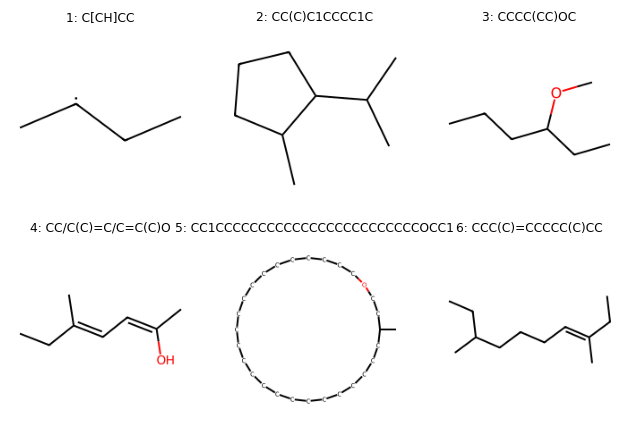

In [ ]:
tot           = len(gen_df)
n_invalid     = 0      # SMILES cannot be parsed
n_duplicate   = 0      # canonical SMILES already seen
n_not_novel   = 0      # present in training set
survivors     = []

seen = set()

for s in tqdm(gen_df.smiles, total=tot):
    m = mol(s)
    if m is None:
        n_invalid += 1
        continue

    cs = Chem.MolToSmiles(m, canonical=True)
    if cs in seen:
        n_duplicate += 1
        continue

    if not is_novel(cs):
        n_not_novel += 1
        continue

    seen.add(cs)
    survivors.append(
        {"smiles": cs, "C": n_C(m), "MW": Descriptors.MolWt(m)}
    )

stage1_df = pd.DataFrame(survivors)

# Summary report
print("Stage 1 summary")
print(f"  total input        : {tot:,}")
print(f"  invalid SMILES     : {n_invalid:,}")
print(f"  duplicates removed : {n_duplicate:,}")
print(f"  not novel enough   : {n_not_novel:,}")
print(f"  survivors          : {len(stage1_df):,}")

print('Stage 1 examples:')
# Display graphs of 6 random molecules from stage 1 using rdkit
fig, axs = plt.subplots(2, 3, figsize=(6, 4))
for i, s in enumerate(stage1_df.smiles.sample(6)):
    m = mol(s)
    if m is not None:
        img = Draw.MolToImage(m, size=(200, 200))
        axs[i // 3, i % 3].imshow(img)
        axs[i // 3, i % 3].set_title(f"{i+1}: {s}")
        axs[i // 3, i % 3].axis('off')
    else:
        axs[i // 3, i % 3].axis('off')

# decrease font size of titles
for ax in axs.flat:
    ax.title.set_fontsize(8)
    ax.title.set_y(0.9)
plt.tight_layout()
plt.show()


### Quick visuals

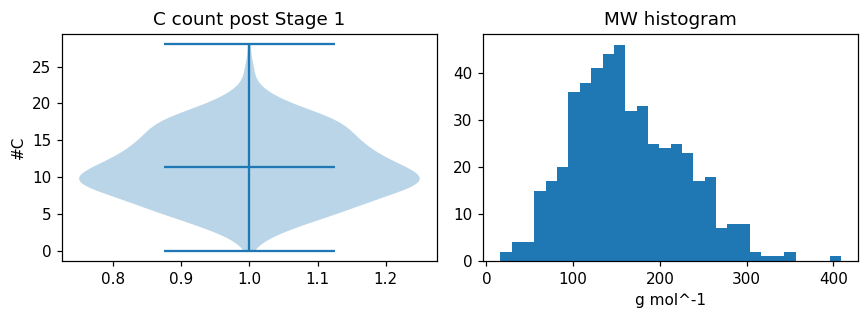

In [6]:
# Plot violinplots of C count and MW for stage 1
fig,axs=plt.subplots(1,2,figsize=(8,3))
axs[0].violinplot(stage1_df['C'], showmeans=True)
axs[0].set_title('C count post Stage 1')
axs[0].set_ylabel('#C')
axs[1].hist(stage1_df['MW'], bins=30)
axs[1].set_title('MW histogram')
axs[1].set_xlabel('g mol^-1')
plt.tight_layout()
for ax in axs:
    ax.grid(False)
plt.show()

## Stage 2 - five gates

100%|██████████| 494/494 [00:00<00:00, 2531.92it/s]


Stage 2 summary
  start size        : 494
  failed composition: 32
  failed forbidden : 56
  failed unsat     : 21
  failed ring      : 303
  failed flash     : 29
  survivors         : 106
Post stage 2 examples:


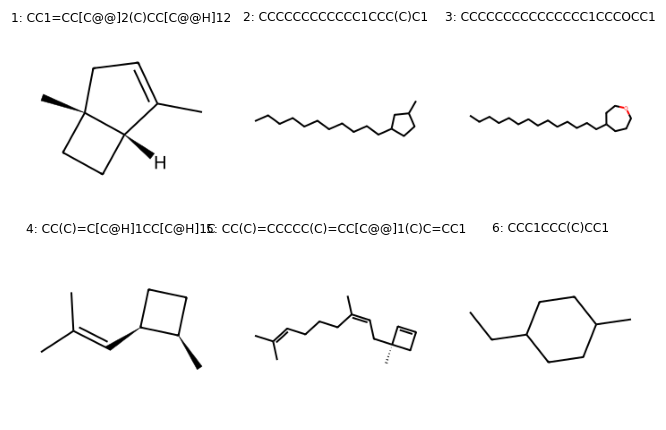

In [ ]:

counts = {
    "composition": 0,
    "forbidden":   0,
    "unsat":       0,
    "ring":        0,
    #"Tb":          0,
    "flash":       0,
    #"rho":         0,
}
survivors = []

for s in tqdm(stage1_df.smiles, total=len(stage1_df)):
    m = mol(s)

    if not composition_ok(m):
        counts["composition"] += 1
        continue

    if forbidden(m):
        counts["forbidden"] += 1
        continue

    if c_double(m) > PARAMS["max_cdouble"]:
        counts["unsat"] += 1
        continue

    if not ring_ok(m):
        counts["ring"] += 1
        continue
    
    # accuracy questionable and this step filtered out too many molecules. Commenting out for now, possible future improvement. 
    tb_c = tb(s)
    #if not (PARAMS["Tb_min"] <= tb_c <= PARAMS["Tb_max"]):
    #    counts["Tb"] += 1
    #    continue

    fp_c = flash_point(tb_c)
    if fp_c < PARAMS["flashpoint_min"]:
        counts["flash"] += 1
        continue

    r = rho(m)

    # passed all five
    survivors.append({
    "smiles"     : s,
    "Tb_C"       : tb_c,
    "FP_C"       : fp_c,
    "rho_gcm3"   : r,             
    "E_vol_MJ_L" : e_vol(m),
    "C_dbl_eq"   : c_double(m),
    "ring_ok"    : True            
    })

stage2_df = pd.DataFrame(survivors).sort_values("E_vol_MJ_L", ascending=False).reset_index(drop=True)

# Summary report for Stage 2
print("Stage 2 summary")
print(f"  start size        : {len(stage1_df):,}")
for k, v in counts.items():
    print(f"  failed {k:<10}: {v:,}")
print(f"  survivors         : {len(stage2_df):,}")

print('Post stage 2 examples:')
# Display graphs of 6 random molecules from stage 2 using rdkit
fig, axs = plt.subplots(2, 3, figsize=(6, 4))
for i, s in enumerate(stage2_df.smiles.sample(6)):
    m = mol(s)
    if m is not None:
        img = Draw.MolToImage(m, size=(200, 200))
        axs[i // 3, i % 3].imshow(img)
        axs[i // 3, i % 3].set_title(f"{i+1}: {s}")
        axs[i // 3, i % 3].axis('off')
    else:
        axs[i // 3, i % 3].axis('off')

# decrease font size of titles
for ax in axs.flat:
    ax.title.set_fontsize(8)
    ax.title.set_y(0.9)
plt.tight_layout()
plt.show()


### Scatter Tb vs density - quick visual

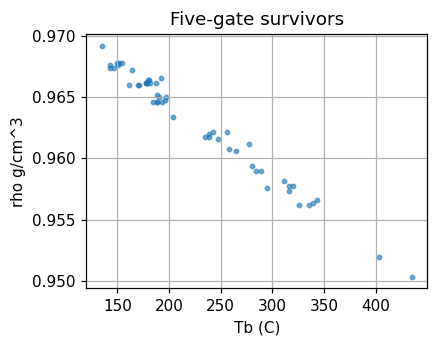

In [ ]:

plt.figure(figsize=(4,3))
plt.scatter(stage2_df.Tb_C, stage2_df.rho, s=8, alpha=0.6)
plt.xlabel('Tb (C)');plt.ylabel('rho g/cm^3');plt.title('Five-gate survivors')
plt.show()


## Save top molecules as a grid drawing

In [9]:
stage2_ranked_df = stage2_df.sort_values("E_vol_MJ_L", ascending=False).reset_index(drop=True)

In [25]:
top12_smiles = stage2_ranked_df.smiles.head(12).tolist()
top12 = [mol(s) for s in top12_smiles]

# Create and save PNG image
img_png = MolsToGridImage(
    top12, molsPerRow=4, subImgSize=(200,200),
    legends=[f"{i+1}: {s}" for i, s in enumerate(top12_smiles)],
    useSVG=False
)
with open("top12_molecules.png", "wb") as f:
    f.write(img_png.data)

# Create and save SVG image (vector graphics)
img_svg = MolsToGridImage(
    top12, molsPerRow=4, subImgSize=(200,200),
    legends=[f"{i+1}: {s}" for i, s in enumerate(top12_smiles)],
    useSVG=True
)
with open("top12_molecules.svg", "w") as f:
    f.write(img_svg.data)

### More visualisations

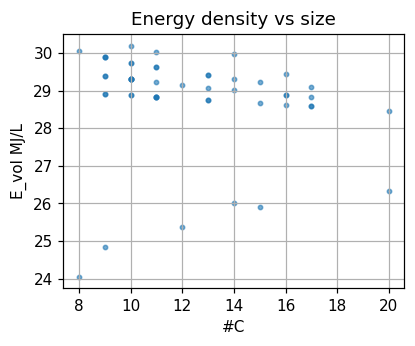

In [ ]:

plt.figure(figsize=(4,3))
plt.scatter([n_C(mol(s)) for s in stage2_df.smiles], stage2_df.E_vol_MJ_L, s=8, alpha=0.6)
plt.xlabel('#C');plt.ylabel('E_vol MJ/L');plt.title('Energy density vs size')
plt.show()


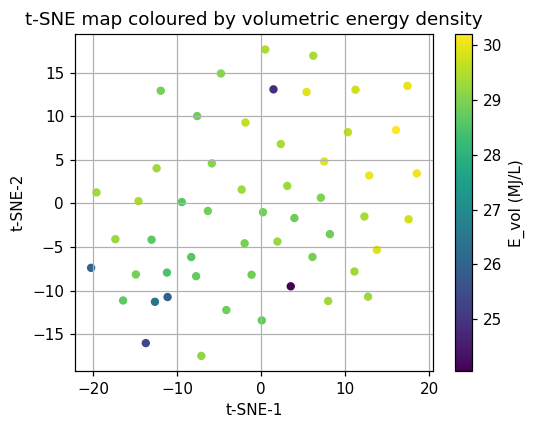

In [ ]:
from sklearn.manifold import TSNE
from rdkit import DataStructs
# fingerprints
fps = [fp(mol(s)) for s in stage2_df.smiles]
# convert to NumPy bits
import numpy as np
fp_list = []
for f in fps:
	arr = np.zeros((2048,), dtype=int)
	DataStructs.cDataStructs.ConvertToNumpyArray(f, arr)
	fp_list.append(arr)
fp_array = np.array(fp_list)
# t‑SNE
emb = TSNE(n_components=2, perplexity=15, random_state=42, init='random').fit_transform(fp_array)
plt.figure(figsize=(5,4))
plt.scatter(emb[:,0], emb[:,1], c=stage2_df["E_vol_MJ_L"], cmap='viridis', s=20)
plt.colorbar(label="E_vol (MJ/L)")
plt.title("t-SNE map coloured by volumetric energy density")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
# save the figure as csv
plt.tight_layout()
plt.savefig("tsne_energies.png", dpi=300)
plt.show()

## Save CSVs

In [13]:

stage1_df.to_csv('saf_stage1.csv',index=False)
stage2_df.to_csv('saf_stage2.csv',index=False)
stage2_ranked_df.to_csv('saf_stage2_ranked.csv', index=False)

print('CSV files written.')


CSV files written.
